<a href="https://colab.research.google.com/github/orin00/colab/blob/main/240422_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install imageio

In [1]:
import tensorflow as tf
import glob # 파일 경로, 폴더 생성
import matplotlib.pyplot as plt # 이미지 확인
import numpy as np
import os # 외부 파일 사용
import PIL # Python Image Library : 이미지 파일 불러오기
from tensorflow.keras import layers
import time
import imageio
from IPython import display

In [2]:
# train 데이터셋만 사용, test 데이터는 불필요
# 생성모델이기 떄문에 생성되는 데이터만 필요하고 생성데이터와 테스트데이터의 비교는 불필요
(train_images, train_labels), (_,_) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
# Shape
print(train_images.shape, train_labels.shape)

(60000, 28, 28) (60000,)


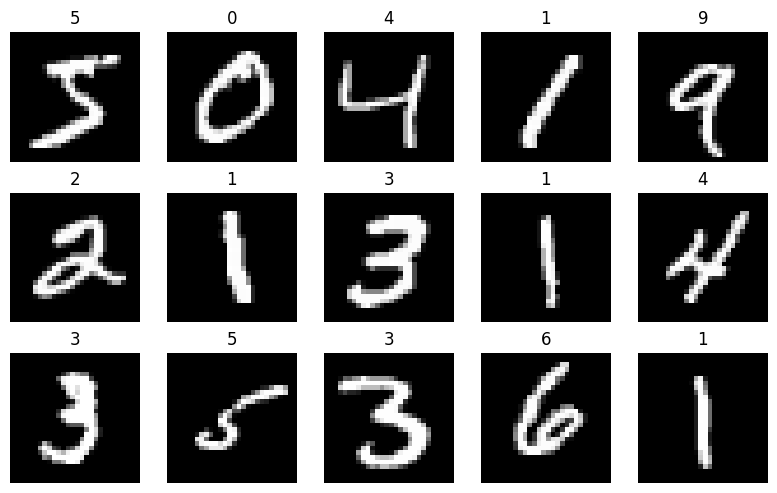

In [4]:
## 이미지 확인
fig, axes = plt.subplots(3, 5)
fig.set_size_inches(8, 5)

for i in range(15):
    ax = axes[i//5, i%5]
    ax.imshow(train_images[i], cmap='gray')
    ax.axis('off')
    ax.set_title(str(train_labels[i]))

plt.tight_layout()
plt.show()

In [5]:
## 3차원 이미지 데이터로 변경
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

In [6]:
train_images.shape

(60000, 28, 28, 1)

In [7]:
train_images[0]

array([[[  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.]],

       [[  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.]],

       [[  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
    

In [8]:
# train 데이터 스케일링
# train_images = train_images / 255 # 0 ~ 1 사이의 값 (MINMAX Scaling)
train_images = (train_images - 127.5) / 127.5 # -1 ~ 1 사이의 값

In [9]:
## train dataset의 크기 지정 (그래픽 카드를 사용해야 하므로 크기 조정 미리 하는게 나음)
BUFFER_SIZE = train_images.shape[0]
BATCH_SIZE = 256 # 한번에 학습되는 양을 조금 줄임

In [10]:
## Batch 지정 및 데이터 셔플
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [11]:
train_dataset

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

In [12]:
# 모델 만들기
# 생성자(Generator)
def make_generator_model():
    model = tf.keras.Sequential()
    # 입력층인데... 1차원 데이터로 입력받음. 7*7*256(12544) Node로 전달
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization()) # BatchNormalization() Batch_size 로 나눈것을 합칠때 값들을 정규분포 형태로 합칠 수 있도록
    model.add(layers.LeakyReLU()) # 손실 함수

    model.add(layers.Reshape((7,7,256))) # 데이터셋 Upscaling
    assert model.output_shape == (None, 7, 7, 256) # 모델 출력 형태를 확인해서 알려줌

    ## CNN층 설계
    model.add(layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False)) # Conv2DTranspose는 역합성곱으로, 크기는 그대로고 채널 수만 줄임
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    ## 2번째 CNN층 설계
    model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False)) # padding='same'은 크기를 줄이지 않겠다. use_bias=False는 계산량 줄이려고.
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    ## 최종 출력 형태인 28*28*1을 만들기
    model.add(layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
    # train_images = (train_images - 127.5) / 127.5 해서
    # -1 ~ 1 사이의 값이 나오니까 하이퍼볼릭 탄젠트 함수 사용
    assert model.output_shape == (None, 28, 28, 1)

    return model

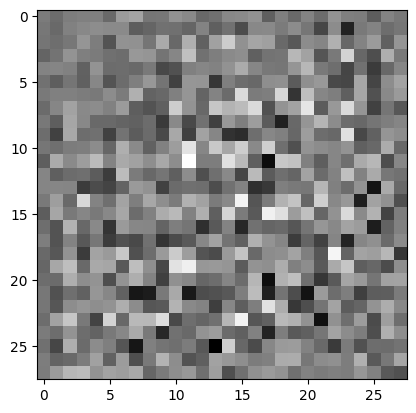

In [13]:
generator = make_generator_model()
values = tf.random.normal([1,100])
generator_image = generator(values, training=False)
plt.imshow(generator_image[0,:,:,0], cmap='gray')
# 아무것도 학습이 안 된 상태의 결과물
# 진짜 아무 의미없는 값이나 출력한 거

In [14]:
## 감별자 만들기 (Discriminator) == CNN 기반 이진 분류기
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3)) # 과적합 방지 => 학습된 가중치의 30%를 삭제

    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # 출력층
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

In [15]:
discriminator = make_discriminator_model()
decision = discriminator(generator_image)
print(decision)

tf.Tensor([[-0.00137308]], shape=(1, 1), dtype=float32)


In [16]:
## 손실 함수와 옵티마이저 정의
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) # 이진 분류 손실 함수

In [17]:
## 감별자 손실
## 감별자는 가짜를 0으로 감별하고, 진짜를 1로 감별
## real 이미지에 대한 감별결과 : 1
## fake 이미지에 대한 감별결과 : 0
def discriminator_loss(real_output, fake_output):
    # 1로 만들어진 배열을 생성하고 real_output과 비교
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # 0으로 만들어진 배열을 생성하고 fake_output과 비교
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [18]:
## 생성자 손실 함수
## 생성자는 0인 데이터를 생성하지만 실제 1인 데이터로 판단하도록 손실값을 만듬
## 생성자와 감별자는 같은 손실함수를 사용할 수 없다.
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [19]:
## 경사하강법(optimizer)는 두 네트워크를 별도로 훈련하기 때문에 서로 따로 정의하지만
## 종류는 같은 것을 써도 된다.(Adam)
generator_optimizer = tf.keras.optimizers.Adam(1e-4) # 괄호 안의 숫자'1e-4'는 learnning rate = 0.0001
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [20]:
## 체크포인트 저장
checkpoint_dir = 'training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

In [21]:
## 훈련 루프 정의하기
EPOCHS = 50
noise_dim = 100 # 노이즈 벡터의 차원
num_examples_to_generate = 16 # 이미지 갯수

# 생성자는 입력으로 임의의 시드값을 받게 되고 입력을 받으면 훈련 루프가 실행
seed = tf.random.normal([num_examples_to_generate, noise_dim]) # 입력으로 쓰이게 될 랜덤한 값의 seed

In [22]:
## 이미지 한장 학습
## 생성자 : 입력을 받고 가짜 이미지 생성 -> 실제와 유사하도록 가중치 업데이트
## 감별자 : 진짜와 가짜를 입력으로 받고 실제와 가짜를 잘 분류하는 방향으로 가중치 업데이트
def train_step(images):
    ## 노이즈 입력 생성 : 입력값
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    ## tf.GradientTape() : 자동 미분 모듈
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # 가짜 이미지 생성
        generated_images = generator(noise, training=True)

        # 판별값 진짜 몇 %, 가짜 몇 %
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # 손실 함수 계산 => loss 값 뽑기
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # 손실 함수 계산 결과에 따라 그래디언트 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # 옵티마이저 적용
    # trainable_variables : 학습 가능한 변수들
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [23]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch+1, seed)

        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        print(f'Time for epochs {epoch+1} is {time.time()-start} sec')

    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [24]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow(predictions[i,:,:,0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig(f'image_at_epoch_{epoch}.png')
    plt.show()

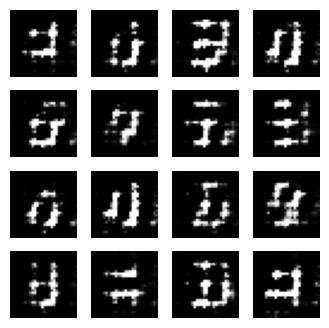

Time for epochs 4 is 41.43850755691528 sec


KeyboardInterrupt: 

In [25]:
train(train_dataset, EPOCHS)

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  print(filenames)
  filenames = sorted(filenames)
  for i, filename in enumerate(filenames):
    frame = 2*(i**0.5)
    print(frame)
    if round(frame) > round(-1):
      last = frame
    else:
      continue
    print(last)

    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename='/content/dcgan.gif')

In [ ]:
try:
  from google.colab import  files
except ImportError:
  pass
else:
  files.downloads(anim_file)